In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# ============================================================
# AE-LPV PINN for Van der Pol — train + MPC control (end-to-end)
# ============================================================

from __future__ import annotations
import math
import random
import time
import logging
from dataclasses import dataclass, asdict
from contextlib import nullcontext
from typing import Optional, Tuple, Dict, List

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad

# Optional: CasADi for MPC (required for control section)
import casadi as ca

# ------------------------------
# Logging
# ------------------------------
logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")
log = logging.getLogger("PINN-VDP")

# ------------------------------
# Repro & perf knobs
# ------------------------------
def set_seed(seed: Optional[int], deterministic: bool = False):
    if seed is None:
        return
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def torch_setup(float32_matmul_precision: str = "high"):
    try:
        torch.set_float32_matmul_precision(float32_matmul_precision)  # "high" or "medium"
    except Exception:
        pass

# ============================================================
# Latin Hypercube + Helpers
# ============================================================
def lhs(n: int, d: int, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    """Latin Hypercube Sampling in [0,1]^d."""
    rng = np.random.default_rng() if rng is None else rng
    cut = np.linspace(0, 1, n + 1)
    H = np.empty((n, d), dtype=np.float64)
    for j in range(d):
        u = rng.random(n)
        a, b = cut[:n], cut[1:]
        s = a + (b - a) * u
        H[:, j] = s[rng.permutation(n)]
    return H

def farthest_point_subset(X: np.ndarray, k: int, metric_scales: Optional[np.ndarray] = None) -> np.ndarray:
    """Greedy FPS over rows of X (Euclidean with per-dim scales)."""
    N = X.shape[0]
    if N == 0:
        return np.empty((0,), dtype=int)
    k = min(k, N)
    if metric_scales is None:
        metric_scales = np.ones(X.shape[1], dtype=np.float64)
    Xn = X / metric_scales
    rng = np.random.default_rng()
    start = int(rng.integers(0, N))
    centers = [start]
    dists = np.linalg.norm(Xn - Xn[start], axis=1)
    for _ in range(1, k):
        idx = int(np.argmax(dists))
        centers.append(idx)
        dists = np.minimum(dists, np.linalg.norm(Xn - Xn[idx], axis=1))
    return np.asarray(centers, dtype=int)

# ============================================================
# Van der Pol Physics + Jacobians + RK4
# ============================================================
@dataclass
class VdPParams:
    mu: float = 1.0

def vdp_f_torch(y: torch.Tensor, u: torch.Tensor, mu: float = 1.0) -> torch.Tensor:
    """f(y,u) for Van der Pol: y' = [y2, μ(1−y1²)y2 − y1 + u]."""
    y1, y2 = y[..., 0], y[..., 1]
    return torch.stack((y2, mu * (1 - y1**2) * y2 - y1 + u[..., 0]), dim=-1)

def j_f_wrt_y(y: torch.Tensor, mu: float = 1.0) -> torch.Tensor:
    """Jacobian ∂f/∂y for Van der Pol, shape (..., 2, 2)."""
    y1, y2 = y[..., 0], y[..., 1]
    J11 = torch.zeros_like(y1)
    J12 = torch.ones_like(y1)
    J21 = -2.0 * mu * y1 * y2 - 1.0
    J22 = mu * (1.0 - y1**2)
    return torch.stack([torch.stack([J11, J12], dim=-1),
                        torch.stack([J21, J22], dim=-1)], dim=-2)

def j_f_wrt_u(y: torch.Tensor, mu: float = 1.0) -> torch.Tensor:
    """Jacobian ∂f/∂u for Van der Pol, shape (..., 2, 1)."""
    B = torch.zeros(y.shape[0], 2, 1, device=y.device, dtype=y.dtype)
    B[:, 1, 0] = 1.0
    return B

def rk4_step(y: torch.Tensor, u: torch.Tensor, dt: float, mu: float) -> torch.Tensor:
    """One RK4 step for y' = f(y,u)."""
    k1 = vdp_f_torch(y, u, mu)
    k2 = vdp_f_torch(y + 0.5 * dt * k1, u, mu)
    k3 = vdp_f_torch(y + 0.5 * dt * k2, u, mu)
    k4 = vdp_f_torch(y + dt * k3, u, mu)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ============================================================
# Model: Scheduler + A/B heads + Control head + PINN core
# ============================================================
class AEEncoder(nn.Module):
    def __init__(self, nx=2, nu=1, ntheta=4, nh=64, act=nn.SiLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nx+nu, nh), act(),
            nn.Linear(nh, nh), act(),
            nn.Linear(nh, ntheta)
        )
        self.out_act = nn.Tanh()

    def forward(self, y: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        return self.out_act(self.net(torch.cat([y, u], dim=-1)))  # θ ∈ [-1,1]

class AffineAB(nn.Module):
    """
    If stable_A=True: A(θ) = skew(A_aff) - α(θ) I (Hurwitz).
    Else: A_affine only.
    """
    def __init__(self, nx=2, nu=1, ntheta=4, a_scale=0.05, b_scale=0.05, stable_A=True, alpha_min=1e-3):
        super().__init__()
        self.nx, self.nu, self.ntheta = nx, nu, ntheta
        self.stable_A = stable_A
        self.alpha_min = float(alpha_min)

        self.A0 = nn.Parameter(torch.randn(nx, nx) * a_scale)
        self.B0 = nn.Parameter(torch.randn(nx, nu) * b_scale)
        self.Aj = nn.Parameter(torch.randn(ntheta, nx, nx) * a_scale)
        self.Bj = nn.Parameter(torch.randn(ntheta, nx, nu) * b_scale)

        if stable_A:
            self.alpha0 = nn.Parameter(torch.tensor(0.1))
            self.alphaj = nn.Parameter(torch.zeros(ntheta))

    @staticmethod
    def _skew(M: torch.Tensor) -> torch.Tensor:
        return 0.5 * (M - M.transpose(-2, -1))

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:
        A_aff = self.A0.unsqueeze(0) + torch.einsum('bj,jkl->bkl', theta, self.Aj)
        B     = self.B0.unsqueeze(0) + torch.einsum('bj,jkl->bkl', theta, self.Bj)
        if not self.stable_A:
            return A_aff, B, None
        S = self._skew(A_aff)
        alpha = torch.nn.functional.softplus(self.alpha0 + torch.einsum('bj,j->b', theta, self.alphaj)) + self.alpha_min
        I = torch.eye(self.nx, device=A_aff.device, dtype=A_aff.dtype).unsqueeze(0)
        A = S - alpha.view(-1, 1, 1) * I
        return A, B, alpha

class AELPV_PINN(nn.Module):
    """
    PINN y(t) with AE-based θ(y,u) and affine (stable) A(θ),B(θ).
    Optional control head û(y,θ,y_ref).
    """
    def __init__(self, T: float, nx=2, nu=1, ntheta=4,
                 n_hidden=4, n_nodes=64, act=nn.SiLU,
                 stable_A=True, use_control_head=True):
        super().__init__()
        self.T = float(T)
        self.nx, self.nu = nx, nu

        # Trunk
        layers = [nn.Linear(1+nx+nu, n_nodes), act()]
        for _ in range(n_hidden-1):
            layers += [nn.Linear(n_nodes, n_nodes), act()]
        layers += [nn.Linear(n_nodes, nx)]
        self.fcn = nn.Sequential(*layers)
        for m in self.fcn:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

        # Heads
        self.encoder = AEEncoder(nx=nx, nu=nu, ntheta=ntheta, nh=64, act=act)
        self.ab = AffineAB(nx=nx, nu=nu, ntheta=ntheta, stable_A=stable_A)
        self.ctrl_head = (nn.Sequential(
            nn.Linear(nx + ntheta + nx, 64), act(),
            nn.Linear(64, 64), act(),
            nn.Linear(64, nu)
        ) if use_control_head else None)

    def forward(self, t: torch.Tensor, y0: torch.Tensor, u: torch.Tensor, y_ref=None, return_aux: bool=False):
        if not t.requires_grad:
            t = t.requires_grad_()
        x = torch.cat([t/self.T, y0/3.0, u], dim=-1)
        y_pred = self.fcn(x)

        if not return_aux:
            return y_pred

        # Batched ∂y/∂t
        dy_dt = []
        ys = y_pred.split(1024, dim=0)  # chunk to save memory
        ts = t.split(1024, dim=0)
        for y_chunk, t_chunk in zip(ys, ts):
            s = []
            for i in range(y_chunk.shape[-1]):
                d = grad(y_chunk[:, i].sum(), t_chunk, create_graph=True, allow_unused=True)[0]
                if d is None: d = torch.zeros_like(t_chunk)
                s.append(d)
            dy_dt.append(torch.stack(s, dim=-1).squeeze(1))
        dy_dt = torch.cat(dy_dt, dim=0)

        theta = self.encoder(y_pred, u)
        A, B, alpha = self.ab(theta)
        dy_lpv = torch.einsum('bij,bj->bi', A, y_pred) + torch.einsum('bij,bj->bi', B, u)

        u_hat = None
        if self.ctrl_head is not None:
            if y_ref is None:
                y_ref = torch.zeros_like(y_pred)
            u_hat = self.ctrl_head(torch.cat([y_pred, theta, y_ref], dim=-1))

        aux = dict(theta=theta, A=A, B=B, alpha=alpha, dy_dt=dy_dt, dy_lpv=dy_lpv, u_hat=u_hat)
        return y_pred, aux

    @torch.no_grad()
    def lpv_dynamics_from_state(self, y: torch.Tensor, u: torch.Tensor):
        theta = self.encoder(y, u)
        A, B, alpha = self.ab(theta)
        dy = torch.einsum('bij,bj->bi', A, y) + torch.einsum('bij,bj->bi', B, u)
        u_hat = None if self.ctrl_head is None else self.ctrl_head(torch.cat([y, theta, torch.zeros_like(y)], dim=-1))
        return dy, theta, A, B, u_hat

# ============================================================
# Loss
# ============================================================
def pinn_ae_loss(model: AELPV_PINN,
                 t: torch.Tensor, y0: torch.Tensor, u: torch.Tensor,
                 y_true: Optional[torch.Tensor] = None,
                 mu_vdp: float = 1.0,
                 w_data=1.0, w_res=1.0, w_ae=0.5, w_vdp=0.0,
                 w_ctrl=0.2, w_theta_entropy=0.01,
                 w_track=0.3, dt_hint: Optional[float] = None) -> Tuple[torch.Tensor, Dict[str,float]]:

    y_pred, aux = model(t, y0, u, y_ref=y_true, return_aux=True)
    theta, A, B = aux['theta'], aux['A'], aux['B']
    dy_dt, dy_lpv = aux['dy_dt'], aux['dy_lpv']
    u_hat = aux['u_hat']

    loss = torch.zeros((), device=y0.device, dtype=y0.dtype)
    logs: Dict[str, float] = {}

    # 1) Supervised
    if y_true is not None and w_data > 0:
        l_data = torch.mean((y_pred - y_true)**2)
        loss = loss + w_data*l_data
        logs['data'] = float(l_data.detach())

    # 2) PINN residual
    if w_res > 0:
        l_res = torch.mean((dy_dt - dy_lpv)**2)
        loss = loss + w_res*l_res
        logs['res'] = float(l_res.detach())

    # 3) AE one-step consistency (RK4 w.r.t. LPV at y0)
    if w_ae > 0 and dt_hint is not None:
        def lpv_rhs(y, u):
            th = model.encoder(y, u)
            A0, B0, _ = model.ab(th)
            return torch.einsum('bij,bj->bi', A0, y) + torch.einsum('bij,bj->bi', B0, u)
        k1 = lpv_rhs(y0, u)
        k2 = lpv_rhs(y0 + 0.5*dt_hint*k1, u)
        k3 = lpv_rhs(y0 + 0.5*dt_hint*k2, u)
        k4 = lpv_rhs(y0 + dt_hint*k3, u)
        y_rk4 = y0 + (dt_hint/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        l_ae = torch.mean((y_pred - y_rk4)**2)
        loss = loss + w_ae*l_ae
        logs['ae'] = float(l_ae.detach())

    # 4) True-physics nudge
    if w_vdp > 0:
        f_vdp = vdp_f_torch(y_pred, u, mu_vdp)
        l_vdp = torch.mean((dy_lpv - f_vdp)**2)
        loss = loss + w_vdp*l_vdp
        logs['vdp'] = float(l_vdp.detach())

    # 5) Control-head tie
    if (u_hat is not None) and w_ctrl > 0:
        l_ctrl = torch.mean((u_hat - u)**2)
        loss = loss + w_ctrl*l_ctrl
        logs['uhead'] = float(l_ctrl.detach())

    # 6) Scheduler entropy (prevent collapse)
    if w_theta_entropy > 0:
        p = torch.softmax(theta, dim=-1)
        H = -torch.sum(p*torch.log(torch.clamp(p, min=1e-8)), dim=-1).mean()
        loss = loss - w_theta_entropy * H
        logs['H(theta)'] = float(H.detach())

    # 7) Lightweight regularization on B
    lB = 1e-5 * torch.mean(B**2)
    loss = loss + lB
    logs['Breg'] = float(lB.detach())

    # 8) Jacobian nudges (A≈∂f/∂y, B≈∂f/∂u) — small weights
    Jfy = j_f_wrt_y(y_pred, mu_vdp)
    Jfu = j_f_wrt_u(y_pred, mu_vdp)
    w_Ajac = 5e-2
    w_Bjac = 1e-1
    l_Ajac = torch.mean((A - Jfy)**2)
    l_Bjac = torch.mean((B - Jfu)**2)
    loss = loss + w_Ajac*l_Ajac + w_Bjac*l_Bjac
    logs['Ajac'] = float(l_Ajac.detach())
    logs['Bjac'] = float(l_Bjac.detach())

    # 9) Tracking: y_next under u_hat moves toward y_true
    if (u_hat is not None) and w_track > 0 and dt_hint is not None and y_true is not None:
        dy_mpc = torch.einsum('bij,bj->bi', A, y_pred) + torch.einsum('bij,bj->bi', B, u_hat)
        y_next = y_pred + dt_hint * dy_mpc
        l_track = torch.mean((y_next - y_true)**2)
        loss = loss + w_track * l_track
        logs['track'] = float(l_track.detach())

    return loss, logs

# ============================================================
# EMA (Exponential Moving Average) — optional evaluator
# ============================================================
class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow: Dict[str, torch.Tensor] = {}
        self.backup: Dict[str, torch.Tensor] = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    def apply_shadow(self, model: nn.Module):
        self.backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.backup[n] = p.detach().clone()
                p.data.copy_(self.shadow[n])

    def restore(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.backup:
                p.data.copy_(self.backup[n])
        self.backup = {}

# ============================================================
# Trainer
# ============================================================
@dataclass
class TrainerCfg:
    # problem
    T: float = 0.01
    mu: float = 1.0
    device: Optional[str] = None
    seed: Optional[int] = 42
    deterministic: bool = False

    # net
    nx: int = 2
    nu: int = 1
    ntheta: int = 4
    n_hidden: int = 2
    n_nodes: int = 32
    act: str = "Tanh"           # "Tanh" | "SiLU"
    stable_A: bool = False
    use_control_head: bool = False
    compile: bool = False       # torch.compile if available

    # data
    Nt: int = 500
    Nf: int = 2000
    Nf_per_epoch: int = 8192
    Ny_per_epoch: int = 2048

    # training
    K1: int = 1000
    K2: int = 100
    lr: float = 1e-3
    weight_decay: float = 1e-5
    mixed_precision: bool = False
    grad_clip_norm: float = 1.0
    ema_decay: Optional[float] = 0.999

    # scheduler
    use_cosine_warmup: bool = True
    warmup_epochs: int = 50
    min_lr_ratio: float = 0.05

    # RAR-G
    adaptive_frequency: int = 500
    error_threshold_percentile: float = 75
    refinement_factor: float = 2.0
    rar_topk_ratio: float = 0.2
    rar_num_centers: int = 64
    rar_sigma_t: float = 0.05
    rar_sigma_x: float = 0.30
    rar_sigma_u: float = 0.10
    rar_min_separation: float = 0.05

    # residual mix & regularizers
    w_lpv: float = 1.0
    w_vdp: float = 0.6
    w_uhead: float = 0.3
    w_entropy: float = 0.01

    # validation
    val_K: int = 200
    val_dt: float = 0.01

class HeadedPINNTrainer:
    def __init__(self, cfg: TrainerCfg):
        self.cfg = cfg
        set_seed(cfg.seed, cfg.deterministic)
        torch_setup()

        self.device = cfg.device or ('cuda' if torch.cuda.is_available() else 'cpu')

        act = nn.Tanh if cfg.act.lower() == "tanh" else nn.SiLU
        self.net = AELPV_PINN(
            T=cfg.T, nx=cfg.nx, nu=cfg.nu, ntheta=cfg.ntheta,
            n_hidden=cfg.n_hidden, n_nodes=cfg.n_nodes, act=act,
            stable_A=cfg.stable_A, use_control_head=cfg.use_control_head
        ).to(self.device)

        if cfg.compile and hasattr(torch, "compile"):
            try:
                self.net = torch.compile(self.net, mode="max-autotune")
                log.info("torch.compile enabled.")
            except Exception as e:
                log.warning(f"torch.compile failed: {e}")

        self.mu = float(cfg.mu)

        self._rng = np.random.default_rng(cfg.seed)
        self._mse = nn.MSELoss()

        self.optimizer_name = 'AdamW'
        self._optim = torch.optim.AdamW(self.net.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        self._scaler = torch.cuda.amp.GradScaler(enabled=cfg.mixed_precision and self.device == 'cuda')
        self.autocast_ctx = (torch.amp.autocast(self.device, enabled=cfg.mixed_precision)
                             if hasattr(torch, "amp") else nullcontext())

        self.ema = EMA(self.net, decay=cfg.ema_decay) if cfg.ema_decay else None
        self._epoch = 0

        self._build_scheduler()

        self.y0 = None; self.u0 = None
        self.data_f = None; self.data_y = None
        self.val_y0 = None; self.val_u_seq = None; self.val_traj = None

        self.prepare_data()
        self._build_validation_set()

    # ------------------------------
    # Scheduler
    # ------------------------------
    def _build_scheduler(self):
        if not self.cfg.use_cosine_warmup:
            self._sched = None
            return
        total_epochs = self.cfg.K1 + self.cfg.K2
        def lr_lambda(ep):
            if ep < self.cfg.warmup_epochs:
                return max(1e-8, (ep + 1) / max(1, self.cfg.warmup_epochs))
            # cosine from 1.0 to min_lr_ratio
            progress = (ep - self.cfg.warmup_epochs) / max(1, total_epochs - self.cfg.warmup_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * progress))
            return self.cfg.min_lr_ratio + (1 - self.cfg.min_lr_ratio) * cosine
        self._sched = torch.optim.lr_scheduler.LambdaLR(self._optim, lr_lambda=lr_lambda)

    # ------------------------------
    # Data preparation
    # ------------------------------
    def prepare_data(self):
        log.info("Preparing LHS initial conditions and collocation...")
        rng = self._rng

        # LHS for (y0,u0)
        y0u = lhs(self.cfg.Nt, 3, rng)
        y0_np = -3.0 + 6.0 * y0u[:, :2]
        u0_np = -1.0 + 2.0 * y0u[:, 2:3]

        self.y0 = torch.tensor(y0_np, dtype=torch.float32, device=self.device)
        self.u0 = torch.tensor(u0_np, dtype=torch.float32, device=self.device)

        # Collocation per IC -> flatten
        t_blocks = [lhs(self.cfg.Nf, 1, rng)[:, 0] for _ in range(self.cfg.Nt)]
        t_flat = (self.cfg.T * np.concatenate(t_blocks, axis=0)).astype(np.float32)
        t_collocation = torch.from_numpy(t_flat).to(self.device).view(self.cfg.Nt, self.cfg.Nf, 1)
        x_collocation = self.y0.unsqueeze(1).expand(-1, self.cfg.Nf, -1)
        u_collocation = self.u0.unsqueeze(1).expand(-1, self.cfg.Nf, -1)
        self.data_f = torch.cat((t_collocation, x_collocation, u_collocation), dim=-1).reshape(-1, 4).contiguous()

        # IC supervision tuples [t=0, y0, u0]
        t0 = torch.zeros(self.cfg.Nt, 1, device=self.device)
        self.data_y = torch.cat((t0, self.y0, self.u0), dim=-1).contiguous()

        log.info(f"Initial data_f: {self.data_f.shape}, data_y: {self.data_y.shape}")

    def _build_validation_set(self):
        log.info(f"Building validation set: steps={self.cfg.val_K}, dt={self.cfg.val_dt}")
        self.val_y0 = torch.tensor(self._rng.uniform(-3, 3, size=(1, 2)), dtype=torch.float32, device=self.device)
        self.val_u_seq = torch.tensor(self._rng.uniform(-1, 1, size=(self.cfg.val_K, 1)), dtype=torch.float32, device=self.device)

        y = self.val_y0.clone()
        traj = [y]
        for k in range(self.cfg.val_K):
            u = self.val_u_seq[k:k+1]
            y = rk4_step(y, u, self.cfg.T, self.mu)
            traj.append(y)
        self.val_traj = torch.cat(traj, dim=0)

    # ------------------------------
    # Loss wrappers
    # ------------------------------
    def _loss_y(self, batch_y: torch.Tensor) -> torch.Tensor:
        t = batch_y[:, 0:1]
        y0 = batch_y[:, 1:3]
        u  = batch_y[:, 3:4]
        y_pred = self.net(t, y0, u)
        return self._mse(y_pred, y0)

    def _loss_f(self, batch_f: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, float]]:
        t  = batch_f[:, 0:1].clone().detach().requires_grad_(True)
        y0 = batch_f[:, 1:3]
        u  = batch_f[:, 3:4]

        loss, logs = pinn_ae_loss(
            model=self.net,
            t=t, y0=y0, u=u, y_true=None,
            mu_vdp=self.mu,
            w_data=0.0,
            w_res=self.cfg.w_lpv,
            w_ae=1.0,
            w_vdp=self.cfg.w_vdp,
            w_ctrl=self.cfg.w_uhead,
            w_theta_entropy=self.cfg.w_entropy,
            dt_hint=self.cfg.T
        )
        return loss, logs

    # ------------------------------
    # Adaptive RAR-G regeneration
    # ------------------------------
    def _compute_pointwise_errors(self) -> np.ndarray:
        prev = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        t = self.data_f[:, 0:1].clone().detach().requires_grad_(True)
        y0 = self.data_f[:, 1:3]
        u  = self.data_f[:, 3:4]
        y_pred = self.net(t, y0, u)

        # ∂y/∂t in chunks
        dy_dt = []
        ys = y_pred.split(2048, dim=0)
        ts = t.split(2048, dim=0)
        for y_chunk, t_chunk in zip(ys, ts):
            s = []
            for i in range(y_chunk.shape[-1]):
                d = grad(y_chunk[:, i].sum(), t_chunk, create_graph=False, retain_graph=True, allow_unused=True)[0]
                if d is None: d = torch.zeros_like(t_chunk)
                s.append(d.squeeze(-1))
            dy_dt.append(torch.stack(s, dim=-1))
        dy_dt = torch.cat(dy_dt, dim=0)

        dy_lpv, _, _, _, _ = self.net.lpv_dynamics_from_state(y_pred, u)
        target = (self.cfg.w_lpv * dy_lpv +
                  (self.cfg.w_vdp * vdp_f_torch(y_pred, u, self.mu) if self.cfg.w_vdp > 0 else 0))
        resid = dy_dt - target
        errs = torch.sum(resid ** 2, dim=-1).detach().cpu().numpy()

        torch.set_grad_enabled(prev)
        return errs

    def _enforce_min_sep(self, pts: List[List[float]]) -> List[List[float]]:
        if len(pts) <= 1:
            return pts
        arr = np.array(pts, dtype=np.float64)
        Z = np.hstack([
            arr[:, 0:1] / max(self.cfg.T, 1e-12),
            (arr[:, 1:3] + 3.0) / 6.0,
            (arr[:, 3:4] + 1.0) / 2.0
        ])
        kept = [0]
        for i in range(1, Z.shape[0]):
            if all(np.linalg.norm(Z[i] - Z[j]) >= self.cfg.rar_min_separation for j in kept):
                kept.append(i)
        return [pts[i] for i in kept]

    def _rar_g_regenerate(self):
        log.info(f"[epoch {self._epoch}] RAR-G regeneration...")
        errs = self._compute_pointwise_errors()
        thr = np.percentile(errs, self.cfg.error_threshold_percentile)
        high_idx = np.where(errs > thr)[0]
        if len(high_idx) == 0:
            log.info("  No high-error points; skipping.")
            return

        data_np = self.data_f.detach().cpu().numpy()
        H = data_np[high_idx]  # [t,y1,y2,u]

        Hn = np.hstack([
            H[:, 0:1] / max(self.cfg.T, 1e-12),
            (H[:, 1:3] + 3.0) / 6.0,
            (H[:, 3:4] + 1.0) / 2.0
        ])

        topk = max(1, int(len(H) * self.cfg.rar_topk_ratio))
        top_idx_sorted = high_idx[np.argsort(errs[high_idx])[::-1][:topk]]
        H_top = data_np[top_idx_sorted]
        Hn_top = np.hstack([
            H_top[:, 0:1] / max(self.cfg.T, 1e-12),
            (H_top[:, 1:3] + 3.0) / 6.0,
            (H_top[:, 3:4] + 1.0) / 2.0
        ])
        centers_rel = farthest_point_subset(Hn_top, k=min(self.cfg.rar_num_centers, Hn_top.shape[0]))
        centers = H_top[centers_rel]

        rng = self._rng
        n_adapt = min(int(len(high_idx) * self.cfg.refinement_factor), self.cfg.Nf // 2)
        adaptive: List[List[float]] = []
        if n_adapt > 0 and len(centers) > 0:
            per_center = max(1, n_adapt // len(centers))
            for c in centers:
                t0, y1, y2, u0 = c
                for _ in range(per_center):
                    tt  = float(np.clip(rng.normal(t0, self.cfg.rar_sigma_t * self.cfg.T), 0.0, self.cfg.T))
                    yy1 = float(np.clip(rng.normal(y1, self.cfg.rar_sigma_x), -3.0, 3.0))
                    yy2 = float(np.clip(rng.normal(y2, self.cfg.rar_sigma_x), -3.0, 3.0))
                    uu  = float(np.clip(rng.normal(u0, self.cfg.rar_sigma_u), -1.0, 1.0))
                    adaptive.append([tt, yy1, yy2, uu])

        if len(adaptive) > 1:
            adaptive = self._enforce_min_sep(adaptive)
            log.info(f"  adaptive points after min-sep: {len(adaptive)}")

        n_uniform = self.cfg.Nf - len(adaptive)
        uniform: List[List[float]] = []
        for _ in range(n_uniform):
            ic_idx = int(self._rng.integers(0, self.cfg.Nt))
            y0_val = self.y0[ic_idx].detach().cpu().numpy()
            u0_val = self.u0[ic_idx].detach().cpu().numpy()
            tt = float(self._rng.random() * self.cfg.T)
            uniform.append([tt, float(y0_val[0]), float(y0_val[1]), float(u0_val[0])])

        pts = adaptive + uniform
        self._rng.shuffle(pts)
        self.data_f = torch.tensor(pts, dtype=torch.float32, device=self.device)
        log.info(f"  RAR-G regenerated -> adaptive={len(adaptive)} uniform={len(uniform)} total={len(pts)}")

    # ------------------------------
    # Training & Validation
    # ------------------------------
    def _maybe_adapt(self):
        if (self._epoch >= 1) and (self.cfg.adaptive_frequency > 0) and (self._epoch % self.cfg.adaptive_frequency == 0):
            self._rar_g_regenerate()

    def _sample_batches(self) -> Tuple[torch.Tensor, torch.Tensor]:
        Ny = min(self.cfg.Ny_per_epoch, self.data_y.shape[0])
        Nf = min(self.cfg.Nf_per_epoch, self.data_f.shape[0])
        idx_y = torch.from_numpy(self._rng.integers(0, self.data_y.shape[0], size=Ny)).to(self.device)
        idx_f = torch.from_numpy(self._rng.integers(0, self.data_f.shape[0], size=Nf)).to(self.device)
        return self.data_y[idx_y], self.data_f[idx_f]

    def _switch_to_lbfgs(self):
        log.info(f"[epoch {self._epoch}] Switching optimizer -> LBFGS")
        self.optimizer_name = 'LBFGS'
        self._optim = torch.optim.LBFGS(self.net.parameters(), lr=1.0, max_iter=20, line_search_fn="strong_wolfe")
        self._scaler = None
        self.autocast_ctx = nullcontext()  # AMP off for LBFGS

    def _train_epoch(self) -> Dict[str, float]:
        self.net.train()
        t0 = time.time()
        batch_y, batch_f = self._sample_batches()

        # IC loss
        with self.autocast_ctx:
            loss_y = self._loss_y(batch_y)

        # physics loss
        loss_f, logs_f = self._loss_f(batch_f)

        loss = loss_y + 0.1 * loss_f  # λ=0.1

        if self.optimizer_name == 'LBFGS':
            def closure():
                self._optim.zero_grad(set_to_none=True)
                ly = self._loss_y(batch_y)
                lf, _ = self._loss_f(batch_f)
                l = ly + 0.1 * lf
                l.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.cfg.grad_clip_norm)
                return l
            loss = self._optim.step(closure)
        else:
            self._optim.zero_grad(set_to_none=True)
            if self._scaler is not None:
                self._scaler.scale(loss).backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.cfg.grad_clip_norm)
                self._scaler.step(self._optim)
                self._scaler.update()
            else:
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.cfg.grad_clip_norm)
                self._optim.step()

        if self._sched is not None and self.optimizer_name != 'LBFGS':
            self._sched.step()

        if self.ema is not None and self.optimizer_name != 'LBFGS':
            self.ema.update(self.net)

        dt = time.time() - t0
        return dict(
            all=float(loss.detach().item()),
            y=float(loss_y.detach().item()),
            f=float(loss_f.detach().item()),
            ent=logs_f.get('H(theta)', 0.0),
            sec=dt,
            lr=float(self._optim.param_groups[0]["lr"])
        )

    @torch.inference_mode()
    def _validate_once(self, use_ema: bool = False) -> Dict[str, float]:
        if use_ema and self.ema is not None:
            self.ema.apply_shadow(self.net)
        self.net.eval()

        y = self.val_y0.clone()
        preds = [y]
        for k in range(self.cfg.val_K):
            t_in = torch.tensor([[self.cfg.T]], dtype=torch.float32, device=self.device)
            u_in = self.val_u_seq[k:k+1]
            y = self.net(t_in, y, u_in)
            preds.append(y)
        Yp = torch.cat(preds, dim=0)

        Ygt = self.val_traj
        err = Ygt - Yp
        mse = torch.mean(err**2).item()
        mae = torch.mean(err.abs()).item()
        mxe = torch.max(err.abs()).item()
        fe  = torch.mean(err[-1].abs()).item()

        if use_ema and self.ema is not None:
            self.ema.restore(self.net)

        return dict(all=mse, mae=mae, max_error=mxe, final_error=fe)

    def fit(self):
        total_epochs = self.cfg.K1 + self.cfg.K2
        log.info(f"Device: {self.device}")
        log.info("Config: " + str(asdict(self.cfg)))

        for ep in range(1, total_epochs + 1):
            self._epoch = ep
            if ep == self.cfg.K1 + 1 and self.cfg.K2 > 0:
                self._switch_to_lbfgs()

            self._maybe_adapt()
            logs_tr = self._train_epoch()

            if ep % 25 == 0 or ep == 1 or ep == total_epochs:
                logs_val = self._validate_once(use_ema=False)
                logs_val_ema = self._validate_once(use_ema=True) if self.ema is not None else logs_val
                log.info(
                    f"[{ep:04d}/{total_epochs}] "
                    f"train_all={logs_tr['all']:.4e} y={logs_tr['y']:.4e} f={logs_tr['f']:.4e} "
                    f"lr={logs_tr['lr']:.2e} sec={logs_tr['sec']:.2f} | "
                    f"val_mse={logs_val['all']:.4e} mae={logs_val['mae']:.4e} "
                    f"max={logs_val['max_error']:.4e} final={logs_val['final_error']:.4e} "
                    f"| ema_mse={logs_val_ema['all']:.4e}"
                )
        log.info("Training complete.")

# ============================================================
# --- Control / MPC section ---
# ============================================================

# Torch→NumPy helper (float64-friendly)
def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
    else:
        arr = np.asarray(x)
    return arr

class LPVAdapter:
    """
    Builds discrete LTV (A_d, B_d, c_d) from AE-LPV heads around (x,u) with
    forward Euler and affine correction so the step matches f(x,u) at the point.
    """
    def __init__(self, model: AELPV_PINN, dt: float, device: str = "cpu"):
        self.model = model
        self.dt = float(dt)
        self.device = device

    @torch.no_grad()
    def heads_dt(self, x_np: np.ndarray, u_np: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        x = torch.tensor(x_np[None, :], dtype=torch.float32, device=self.device)
        u = torch.tensor(u_np[None, :], dtype=torch.float32, device=self.device)
        dy, _, A_t, B_t, _ = self.model.lpv_dynamics_from_state(x, u)  # [1,n], [1,n,n], [1,n,m]
        A = A_t[0].detach().cpu().numpy().astype(np.float64)
        B = B_t[0].detach().cpu().numpy().astype(np.float64)
        dy_np = dy[0].detach().cpu().numpy().astype(np.float64)

        I = np.eye(A.shape[0], dtype=np.float64)
        A_d = I + self.dt * A
        B_d = self.dt * B

        # Affine correction for exact match at (x,u)
        resid = dy_np - (A @ x_np + B @ u_np)  # ℝ^n
        c_d = self.dt * resid
        return A_d, B_d, c_d

    @torch.no_grad()
    def build_ltv_sequence(self, x0: np.ndarray, u_seq: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], np.ndarray]:
        N, m = u_seq.shape
        n = x0.shape[0]
        X_nom = np.zeros((N + 1, n), dtype=np.float64)
        X_nom[0] = x0
        A_list: List[np.ndarray] = []
        B_list: List[np.ndarray] = []
        c_list: List[np.ndarray] = []
        xk = x0.copy()
        for k in range(N):
            uk = u_seq[k]
            A, B, c = self.heads_dt(xk, uk)
            A_list.append(A); B_list.append(B); c_list.append(c)
            xk = A @ xk + B @ uk + c
            X_nom[k + 1] = xk
        return A_list, B_list, c_list, X_nom

class CasadiLPVMPC:
    """
    Opti-based LPV MPC (prefers OSQP, falls back to IPOPT).
    Min ∑ (x_k-x_ref)^T Q (x_k-x_ref) + (u_k-u_ref)^T R (u_k-u_ref) + (x_N-x_ref)^T Qf (x_N-x_ref)
    Optional Δu penalty via Rdu.
    """
    def __init__(self, N: int, n: int, m: int,
                 Q: np.ndarray, R: np.ndarray, Qf: np.ndarray,
                 umin: np.ndarray, umax: np.ndarray,
                 xmin: Optional[np.ndarray] = None,
                 xmax: Optional[np.ndarray] = None,
                 Rdu: Optional[np.ndarray] = None,
                 solver_opts: Optional[dict] = None,
                 prefer_qp: bool = True):
        self.N, self.n, self.m = int(N), int(n), int(m)
        self.prefer_qp = bool(prefer_qp)
        self.opti = ca.Opti()

        # Decision variables
        self.X = self.opti.variable(n, N + 1)
        self.U = self.opti.variable(m, N)

        # Parameters
        self.x0   = self.opti.parameter(n)
        self.xref = self.opti.parameter(n)
        self.uref = self.opti.parameter(m)

        self.Ap = [self.opti.parameter(n, n) for _ in range(N)]
        self.Bp = [self.opti.parameter(n, m) for _ in range(N)]
        self.cp = [self.opti.parameter(n)     for _ in range(N)]

        self.Q  = ca.DM(np.asarray(Q,  dtype=np.float64))
        self.R  = ca.DM(np.asarray(R,  dtype=np.float64))
        self.Qf = ca.DM(np.asarray(Qf, dtype=np.float64))

        self.umin = ca.DM(np.asarray(umin, dtype=np.float64)).full().ravel()
        self.umax = ca.DM(np.asarray(umax, dtype=np.float64)).full().ravel()
        self.xmin = None if xmin is None else ca.DM(np.asarray(xmin, dtype=np.float64)).full().ravel()
        self.xmax = None if xmax is None else ca.DM(np.asarray(xmax, dtype=np.float64)).full().ravel()

        self.use_du = Rdu is not None
        if self.use_du:
            Rdu = np.asarray(Rdu, dtype=np.float64)
            self.Rdu = ca.DM(Rdu)
            self.dU = self.opti.variable(m, N)
            self.u_prev = self.opti.parameter(m)
        else:
            self.Rdu = None
            self.dU = None
            self.u_prev = None

        # Objective
        J = 0
        for k in range(N):
            dx = self.X[:, k] - self.xref
            du = self.U[:, k] - self.uref
            J += ca.mtimes([dx.T, self.Q, dx]) + ca.mtimes([du.T, self.R, du])
            if self.use_du:
                duk = (self.U[:, k] - (self.u_prev if k == 0 else self.U[:, k-1]))
                self.opti.subject_to(self.dU[:, k] == duk)
                J += ca.mtimes([duk.T, self.Rdu, duk])

        dxN = self.X[:, self.N] - self.xref
        J += ca.mtimes([dxN.T, self.Qf, dxN])
        self.opti.minimize(J)

        # Dynamics & bounds
        self.opti.subject_to(self.X[:, 0] == self.x0)
        for k in range(N):
            self.opti.subject_to(self.X[:, k + 1] ==
                                 self.Ap[k] @ self.X[:, k] +
                                 self.Bp[k] @ self.U[:, k] +
                                 self.cp[k])

        for k in range(N):
            self.opti.subject_to(self.umin <= self.U[:, k])
            self.opti.subject_to(self.U[:, k] <= self.umax)

        if (self.xmin is not None) and (self.xmax is not None):
            for k in range(1, N + 1):
                self.opti.subject_to(self.xmin <= self.X[:, k])
                self.opti.subject_to(self.X[:, k] <= self.xmax)

        # Inits
        self.opti.set_initial(self.X, 0.0)
        self.opti.set_initial(self.U, 0.0)
        if self.use_du:
            self.opti.set_initial(self.dU, 0.0)

        # Solver
        user_opts = {} if solver_opts is None else dict(solver_opts)
        self._configure_solver(prefer_qp=self.prefer_qp, user_opts=user_opts)

        self._last_sol_X = None
        self._last_sol_U = None
        self._last_sol_dU = None

    def _configure_solver(self, prefer_qp: bool, user_opts: dict):
        base_opts = {"print_time": False}
        ipopt_opts = {"ipopt": {"print_level": 0, "max_iter": 200, "tol": 1e-6, "warm_start_init_point": "yes"}}

        if prefer_qp:
            try:
                # Direct OSQP (preferred)
                osqp_opts = {"verbose": False, "eps_abs": 1e-6, "eps_rel": 1e-6, "max_iter": 20000}
                self.opti.solver("osqp", {**base_opts, **user_opts, **osqp_opts})
                self._solver_used = "osqp"
                return
            except Exception as e:
                print("[MPC] OSQP setup failed; falling back to IPOPT. Reason:", str(e))

        # Fallback: IPOPT
        self.opti.solver("ipopt", {**base_opts, **user_opts, **ipopt_opts})
        self._solver_used = "ipopt"

    def set_params(self, x0, x_ref, u_ref,
                   A_list: List[np.ndarray], B_list: List[np.ndarray], c_list: List[np.ndarray],
                   u_prev: Optional[np.ndarray] = None):
        self.opti.set_value(self.x0,   ca.DM(np.asarray(x0,   dtype=np.float64)))
        self.opti.set_value(self.xref, ca.DM(np.asarray(x_ref,dtype=np.float64)))
        self.opti.set_value(self.uref, ca.DM(np.asarray(u_ref,dtype=np.float64)))
        for k in range(self.N):
            self.opti.set_value(self.Ap[k], ca.DM(np.asarray(A_list[k], dtype=np.float64)))
            self.opti.set_value(self.Bp[k], ca.DM(np.asarray(B_list[k], dtype=np.float64)))
            self.opti.set_value(self.cp[k], ca.DM(np.asarray(c_list[k], dtype=np.float64)))
        if self.use_du and u_prev is not None:
            self.opti.set_value(self.u_prev, ca.DM(np.asarray(u_prev, dtype=np.float64)))

    def solve(self, warm_start: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, bool]:
        if warm_start and (self._last_sol_X is not None):
            self.opti.set_initial(self.X, self._last_sol_X)
            self.opti.set_initial(self.U, self._last_sol_U)
            if self.use_du and (self._last_sol_dU is not None):
                self.opti.set_initial(self.dU, self._last_sol_dU)

        try:
            sol = self.opti.solve()
        except RuntimeError as e:
            if getattr(self, "_solver_used", "") == "osqp":
                print("[MPC] OSQP failed at runtime, switching to IPOPT once. Reason:", str(e))
                self._configure_solver(prefer_qp=False, user_opts={})
                try:
                    sol = self.opti.solve()
                except Exception as e2:
                    print("[MPC] IPOPT also failed:", str(e2))
                    return self._fallback_action()
            else:
                print("[MPC] Solve failed:", str(e))
                return self._fallback_action()

        Xv_raw = np.array(sol.value(self.X))
        Uv_raw = np.array(sol.value(self.U))
        Xv = Xv_raw.reshape(self.n, self.N + 1, order='F')
        Uv = Uv_raw.reshape(self.m, self.N,     order='F')

        self._last_sol_X = sol.value(self.X)
        self._last_sol_U = sol.value(self.U)
        if self.use_du:
            self._last_sol_dU = sol.value(self.dU)

        u0 = Uv[:, 0].copy()
        return u0, Xv, Uv, True

    def _fallback_action(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, bool]:
        if self._last_sol_U is not None:
            Uv = np.array(self._last_sol_U).reshape(self.m, self.N, order='F')
            Xv = np.array(self._last_sol_X).reshape(self.n, self.N + 1, order='F')
            u0 = Uv[:, 0].copy()
        else:
            Uv = np.zeros((self.m, self.N), dtype=np.float64)
            Xv = np.zeros((self.n, self.N + 1), dtype=np.float64)
            u0 = np.zeros((self.m,), dtype=np.float64)
        return u0, Xv, Uv, False

def run_closed_loop_mpc_opti(
    model: AELPV_PINN, rk4_step_fn,
    x0: np.ndarray,
    steps: int, horizon: int, dt: float, mu: float,
    Q, R, Qf, umin, umax, xmin=None, xmax=None,
    x_ref=None, u_ref=None,
    device: str = "cpu",
    nominal_u_init: str = "zeros",
    prefer_qp: bool = True,
    Rdu: Optional[np.ndarray] = None,
):
    n = int(x0.shape[0])
    m = int(umin.shape[0])
    if x_ref is None: x_ref = np.zeros(n, dtype=np.float64)
    if u_ref is None: u_ref = np.zeros(m, dtype=np.float64)

    mpc = CasadiLPVMPC(
        N=horizon, n=n, m=m, Q=Q, R=R, Qf=Qf,
        umin=umin, umax=umax, xmin=xmin, xmax=xmax,
        Rdu=Rdu, prefer_qp=prefer_qp
    )
    adapter = LPVAdapter(model, dt=dt, device=device)

    X_true = np.zeros((steps + 1, n), dtype=np.float64)
    X_pred = np.zeros((steps + 1, n), dtype=np.float64)
    U_applied = np.zeros((steps, m), dtype=np.float64)
    tvec = np.arange(steps, dtype=np.float64) * dt
    X_true[0] = x0
    X_pred[0] = x0

    if nominal_u_init == "zeros":
        u_nom = np.zeros((horizon, m), dtype=np.float64)
    elif nominal_u_init == "hold":
        u_nom = np.tile(u_ref, (horizon, 1)).astype(np.float64)
    else:
        u_nom = np.zeros((horizon, m), dtype=np.float64)

    u_prev = u_ref.copy()
    xk = x0.copy()

    model.eval()  # make sure heads are in eval mode

    for t in range(steps):
        A_list, B_list, c_list, X_nom = adapter.build_ltv_sequence(xk, u_nom)

        mpc.set_params(
            x0=xk, x_ref=x_ref, u_ref=u_ref,
            A_list=A_list, B_list=B_list, c_list=c_list,
            u_prev=(u_prev if Rdu is not None else None)
        )
        u0, Xopt, Uopt, ok = mpc.solve(warm_start=True)

        # Apply to true plant
        y_torch = torch.tensor(xk[None, :], dtype=torch.float32, device=device)
        u_torch = torch.tensor(u0[None, :], dtype=torch.float32, device=device)
        y_next = _to_numpy(rk4_step_fn(y_torch, u_torch, dt, mu))[0].astype(np.float64)

        U_applied[t] = u0
        X_pred[t + 1] = Xopt[:, 1] if Xopt.shape[1] > 1 else (A_list[0] @ xk + B_list[0] @ u0 + c_list[0])
        X_true[t + 1] = y_next
        xk = y_next.copy()
        u_prev = u0.copy()

        # warm start next
        if Uopt.shape[1] > 1:
            u_nom[:-1] = Uopt[:, 1:].T
            u_nom[-1]  = Uopt[:, -1]
        else:
            u_nom[:-1] = u_nom[1:]
            u_nom[-1]  = u_prev

    return tvec, X_true, X_pred, U_applied

def make_weights(n=2, m=1, rdu: Optional[float] = None):
    Q  = np.diag([5.0, 1.0]).astype(np.float64)
    R  = np.diag([0.1]).astype(np.float64)
    Qf = np.diag([8.0, 2.0]).astype(np.float64)
    Rdu = None if (rdu is None or rdu <= 0.0) else (rdu * np.eye(m, dtype=np.float64))
    return Q, R, Qf, Rdu

def run_demo_control(model: AELPV_PINN, rk4_step_fn, x0_np, dt=0.01, mu=1.0, horizon=30, steps=300,
                     device="cpu", prefer_qp: bool = True, rdu: Optional[float] = None):
    n = int(x0_np.shape[0]); m = 1
    Q, R, Qf, Rdu = make_weights(n, m, rdu=rdu)

    umin = np.array([-2.0], dtype=np.float64)
    umax = np.array([ 2.0], dtype=np.float64)
    xmin = np.array([-3.0, -3.0], dtype=np.float64)
    xmax = np.array([ 3.0,  3.0], dtype=np.float64)
    x_ref = np.array([0.0, 0.0], dtype=np.float64)
    u_ref = np.array([0.0], dtype=np.float64)

    return run_closed_loop_mpc_opti(
        model=model, rk4_step_fn=rk4_step_fn,
        x0=x0_np.astype(np.float64),
        steps=steps, horizon=horizon, dt=dt, mu=mu,
        Q=Q, R=R, Qf=Qf, umin=umin, umax=umax, xmin=xmin, xmax=xmax,
        x_ref=x_ref, u_ref=u_ref,
        device=device, nominal_u_init="zeros",
        prefer_qp=prefer_qp, Rdu=Rdu
    )

# ============================================================
# Entry point
# ============================================================
if __name__ == "__main__":
    cfg = TrainerCfg(
        # Training config
        T=0.01, mu=1.0, seed=42, deterministic=False,
        nx=2, nu=1, ntheta=4,
        n_hidden=2, n_nodes=32, act="Tanh",
        stable_A=False, use_control_head=False,
        compile=False,
        Nt=500, Nf=2000, Nf_per_epoch=8192, Ny_per_epoch=2048,
        K1=1000, K2=100, lr=1e-3, mixed_precision=False,
        grad_clip_norm=1.0, ema_decay=0.999,
        use_cosine_warmup=True, warmup_epochs=50, min_lr_ratio=0.05,
        adaptive_frequency=500, error_threshold_percentile=75,
        refinement_factor=2.0, rar_topk_ratio=0.2, rar_num_centers=64,
        rar_sigma_t=0.05, rar_sigma_x=0.30, rar_sigma_u=0.10, rar_min_separation=0.05,
        w_lpv=1.0, w_vdp=0.6, w_uhead=0.3, w_entropy=0.01,
        val_K=200, val_dt=0.01
    )

    # ---- Train ----
    trainer = HeadedPINNTrainer(cfg)
    trainer.fit()

    # Save & prep for control
    torch.save(trainer.net.state_dict(), "pinn_vdp_control_heads.pth")
    log.info("Model saved to pinn_vdp_control_heads.pth")
    model = trainer.net
    device = trainer.device
    dT = cfg.T  # reuse sampling time for control

    # ---- Control demo (closed loop MPC) ----
    x0 = np.array([2.0, 0.0], dtype=np.float64)
    tvec, traj_true, traj_lpv, u_seq = run_demo_control(
        model, rk4_step, x0,
        dt=dT, mu=cfg.mu, horizon=40, steps=500, device=device,
        prefer_qp=False,    # try fast OSQP; auto-fallback to IPOPT
        rdu=0.05           # Δu penalty (set None/0.0 to disable)
    )

    # Persist results (simple .npy dumps; plotting is up to you)
    np.save("ctrl_time.npy", tvec)
    np.save("ctrl_traj_true.npy", traj_true)
    np.save("ctrl_traj_lpv.npy", traj_lpv)
    np.save("ctrl_u_seq.npy", u_seq)
    log.info("Control rollout saved: ctrl_time.npy, ctrl_traj_true.npy, ctrl_traj_lpv.npy, ctrl_u_seq.npy")


/tmp/ipykernel_3578430/2755355384.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler(enabled=cfg.mixed_precision and self.device == 'cuda')
[INFO] Preparing LHS initial conditions and collocation...
[INFO] Initial data_f: torch.Size([1000000, 4]), data_y: torch.Size([500, 4])
[INFO] Building validation set: steps=200, dt=0.01
[INFO] Device: cuda
[INFO] Config: {'T': 0.01, 'mu': 1.0, 'device': None, 'seed': 42, 'deterministic': False, 'nx': 2, 'nu': 1, 'ntheta': 4, 'n_hidden': 2, 'n_nodes': 32, 'act': 'Tanh', 'stable_A': False, 'use_control_head': False, 'compile': False, 'Nt': 500, 'Nf': 2000, 'Nf_per_epoch': 8192, 'Ny_per_epoch': 2048, 'K1': 1000, 'K2': 100, 'lr': 0.001, 'weight_decay': 1e-05, 'mixed_precision': False, 'grad_clip_norm': 1.0, 'ema_decay': 0.999, 'use_cosine_warmup': True, 'warmup_epochs': 50, 'min_lr_ratio': 0.05, 'adaptive_frequency': 500, 'er


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



[INFO] Control rollout saved: ctrl_time.npy, ctrl_traj_true.npy, ctrl_traj_lpv.npy, ctrl_u_seq.npy


In [2]:
model = trainer.net
device = trainer.device

In [ ]:
import numpy as np
import casadi as ca
import torch
from typing import Tuple, List, Optional

# ============================================================
# 0) Torch→NumPy helper
# ============================================================
def _to_numpy(x):
    """Detach → CPU → NumPy with float64 by default for CasADi friendliness."""
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
    else:
        arr = np.asarray(x)
    # Keep double in CasADi side; caller can cast if needed.
    return arr

def run_demo_control(model, rk4_step, x0_np, dt=0.01, mu=1.0, horizon=30, steps=300,
                     device="cpu", prefer_qp: bool = True, rdu: Optional[float] = None):
    """
    One-call demo: builds weights, bounds, runs closed-loop, returns trajectories.
    """
    n = int(x0_np.shape[0]); m = 1
    Q, R, Qf, Rdu = make_weights(n, m, rdu=rdu)

    umin = np.array([-2.0], dtype=np.float64)
    umax = np.array([ 2.0], dtype=np.float64)
    xmin = np.array([-3.0, -3.0], dtype=np.float64)
    xmax = np.array([ 3.0,  3.0], dtype=np.float64)
    x_ref = np.array([0.0, 0.0], dtype=np.float64)
    u_ref = np.array([0.0], dtype=np.float64)

    return run_closed_loop_mpc_opti(
        model=model, rk4_step_fn=rk4_step,
        x0=x0_np.astype(np.float64),
        steps=steps, horizon=horizon, dt=dt, mu=mu,
        Q=Q, R=R, Qf=Qf, umin=umin, umax=umax, xmin=xmin, xmax=xmax,
        x_ref=x_ref, u_ref=u_ref,
        device=device, nominal_u_init="zeros",
        prefer_qp=prefer_qp, Rdu=Rdu
    )

# ============================================================
# 5) Usage (after training) — same as your original
#    (Assumes `model`, `rk4_step`, `dT`, `device` exist.)
# ============================================================
# Example:
x0 = np.array([2.0, 0.0], dtype=np.float64)
tvec, traj_true, traj_lpv, u_seq = run_demo_control(
    model, rk4_step, x0,
    dt=dT, mu=1.0, horizon=40, steps=500, device=device,
    prefer_qp=False,   # try fast OSQP first
    rdu=0.05          # optional Δu penalty; set None or 0 to disable
)
# plot_comparison(tvec, traj_true, traj_lpv, label="MPC AE-LPV (Opti/QP)")


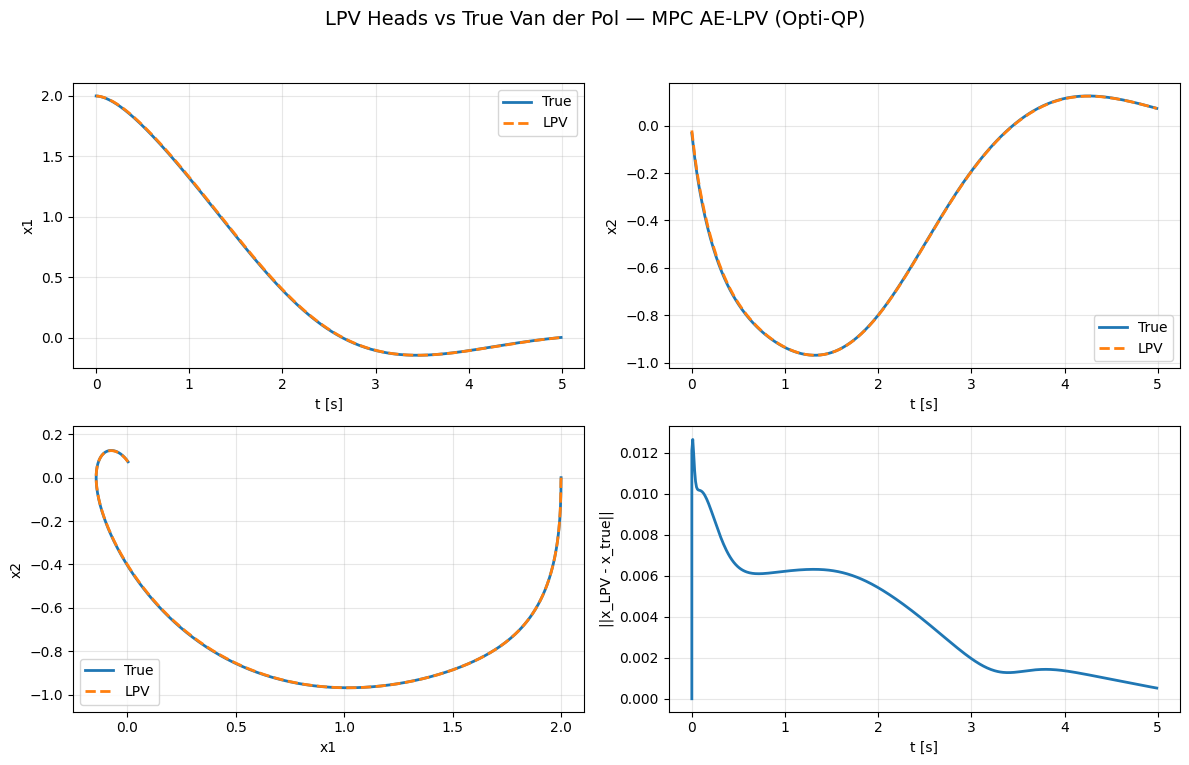

In [7]:
plot_comparison(tvec, traj_true, traj_lpv, label="MPC AE-LPV (Opti-QP)")

In [3]:
# =========================
# Plotting helpers
# =========================
import os
import matplotlib.pyplot as plt


def plot_comparison(tvec, traj_true, traj_lpv, label, save_dir=None):
    """
    traj_* : (T+1, 2) arrays including initial state
    """
    err = traj_lpv - traj_true
    err_norm = np.linalg.norm(err, axis=1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"LPV Heads vs True Van der Pol — {label}", fontsize=14)

    # x1(t)
    axes[0, 0].plot(tvec, traj_true[1:, 0], "-", lw=2, label="True")
    axes[0, 0].plot(tvec, traj_lpv[1:, 0], "--", lw=2, label="LPV")
    axes[0, 0].set_xlabel("t [s]")
    axes[0, 0].set_ylabel("x1")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # x2(t)
    axes[0, 1].plot(tvec, traj_true[1:, 1], "-", lw=2, label="True")
    axes[0, 1].plot(tvec, traj_lpv[1:, 1], "--", lw=2, label="LPV")
    axes[0, 1].set_xlabel("t [s]")
    axes[0, 1].set_ylabel("x2")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Phase portrait
    axes[1, 0].plot(traj_true[:, 0], traj_true[:, 1], "-", lw=2, label="True")
    axes[1, 0].plot(traj_lpv[:, 0], traj_lpv[:, 1], "--", lw=2, label="LPV")
    axes[1, 0].set_xlabel("x1")
    axes[1, 0].set_ylabel("x2")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].axis("equal")

    # Error norm
    axes[1, 1].plot(np.concatenate([[0.0], tvec]), err_norm, lw=2)
    axes[1, 1].set_xlabel("t [s]")
    axes[1, 1].set_ylabel(r"||x_LPV - x_true||")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, f"compare_{label.replace(' ', '_')}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"Saved: {out}")
    plt.show()


def compare_lpv_to_true_with_plots(
    model: AELPV_PINN,
    mu: float,
    dt: float,
    test_cases: List[Dict],
    device: str = "cpu",
    save_dir: Optional[str] = None,
) -> Dict[str, float]:
    """
    Same as compare_lpv_to_true, but also draws plots per case.
    """
    all_errs = []
    for case in test_cases:
        x0 = case["x0"]
        useq = case["u_seq"]
        lab = case.get("label", "case")

        traj_true = rollout_true_vdp(x0, useq, dt, mu, device=device)  # (T+1,2)
        traj_lpv = rollout_lpv_heads(model, x0, useq, dt, device=device)

        err = traj_lpv - traj_true
        rmse = float(np.sqrt(np.mean(err**2)))
        mae = float(np.mean(np.abs(err)))
        mx = float(np.max(np.abs(err)))
        print(
            f"[{lab}]  RMSE={rmse:.4f}  MAE={mae:.4f}  MaxAbs={mx:.4f}  (T={len(useq)} steps)"
        )

        all_errs.append(err)

        # time vector for plots (no point at t=0)
        tvec = np.arange(len(useq), dtype=np.float32) * dt
        plot_comparison(tvec, traj_true, traj_lpv, label=lab, save_dir=save_dir)

    all_errs = np.concatenate(all_errs, axis=0)
    agg = dict(
        RMSE=float(np.sqrt(np.mean(all_errs**2))),
        MAE=float(np.mean(np.abs(all_errs))),
        MaxAbs=float(np.max(np.abs(all_errs))),
    )
    print(
        f"\nAggregate  RMSE={agg['RMSE']:.4f}  MAE={agg['MAE']:.4f}  MaxAbs={agg['MaxAbs']:.4f}"
    )
    return agg


In [4]:
# =========================
# Plotting helpers
# =========================
import os
import matplotlib.pyplot as plt


def plot_comparison(tvec, traj_true, traj_lpv, label, save_dir=None):
    """
    traj_* : (T+1, 2) arrays including initial state
    """
    err = traj_lpv - traj_true
    err_norm = np.linalg.norm(err, axis=1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"LPV Heads vs True Van der Pol — {label}", fontsize=14)

    # x1(t)
    axes[0, 0].plot(tvec, traj_true[1:, 0], "-", lw=2, label="True")
    axes[0, 0].plot(tvec, traj_lpv[1:, 0], "--", lw=2, label="LPV")
    axes[0, 0].set_xlabel("t [s]")
    axes[0, 0].set_ylabel("x1")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # x2(t)
    axes[0, 1].plot(tvec, traj_true[1:, 1], "-", lw=2, label="True")
    axes[0, 1].plot(tvec, traj_lpv[1:, 1], "--", lw=2, label="LPV")
    axes[0, 1].set_xlabel("t [s]")
    axes[0, 1].set_ylabel("x2")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Phase portrait
    axes[1, 0].plot(traj_true[:, 0], traj_true[:, 1], "-", lw=2, label="True")
    axes[1, 0].plot(traj_lpv[:, 0], traj_lpv[:, 1], "--", lw=2, label="LPV")
    axes[1, 0].set_xlabel("x1")
    axes[1, 0].set_ylabel("x2")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].axis("equal")

    # Error norm
    axes[1, 1].plot(np.concatenate([[0.0], tvec]), err_norm, lw=2)
    axes[1, 1].set_xlabel("t [s]")
    axes[1, 1].set_ylabel(r"||x_LPV - x_true||")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, f"compare_{label.replace(' ', '_')}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"Saved: {out}")
    plt.show()


def compare_lpv_to_true_with_plots(
    model: AELPV_PINN,
    mu: float,
    dt: float,
    test_cases: List[Dict],
    device: str = "cpu",
    save_dir: Optional[str] = None,
) -> Dict[str, float]:
    """
    Same as compare_lpv_to_true, but also draws plots per case.
    """
    all_errs = []
    for case in test_cases:
        x0 = case["x0"]
        useq = case["u_seq"]
        lab = case.get("label", "case")

        traj_true = rollout_true_vdp(x0, useq, dt, mu, device=device)  # (T+1,2)
        traj_lpv = rollout_lpv_heads(model, x0, useq, dt, device=device)

        err = traj_lpv - traj_true
        rmse = float(np.sqrt(np.mean(err**2)))
        mae = float(np.mean(np.abs(err)))
        mx = float(np.max(np.abs(err)))
        print(
            f"[{lab}]  RMSE={rmse:.4f}  MAE={mae:.4f}  MaxAbs={mx:.4f}  (T={len(useq)} steps)"
        )

        all_errs.append(err)

        # time vector for plots (no point at t=0)
        tvec = np.arange(len(useq), dtype=np.float32) * dt
        plot_comparison(tvec, traj_true, traj_lpv, label=lab, save_dir=save_dir)

    all_errs = np.concatenate(all_errs, axis=0)
    agg = dict(
        RMSE=float(np.sqrt(np.mean(all_errs**2))),
        MAE=float(np.mean(np.abs(all_errs))),
        MaxAbs=float(np.max(np.abs(all_errs))),
    )
    print(
        f"\nAggregate  RMSE={agg['RMSE']:.4f}  MAE={agg['MAE']:.4f}  MaxAbs={agg['MaxAbs']:.4f}"
    )
    return agg


Device: cuda
[free small]  RMSE=1.4856  MAE=1.1714  MaxAbs=3.3820  (T=300 steps)
Saved: lpv_vs_true_plots/compare_free_small.png


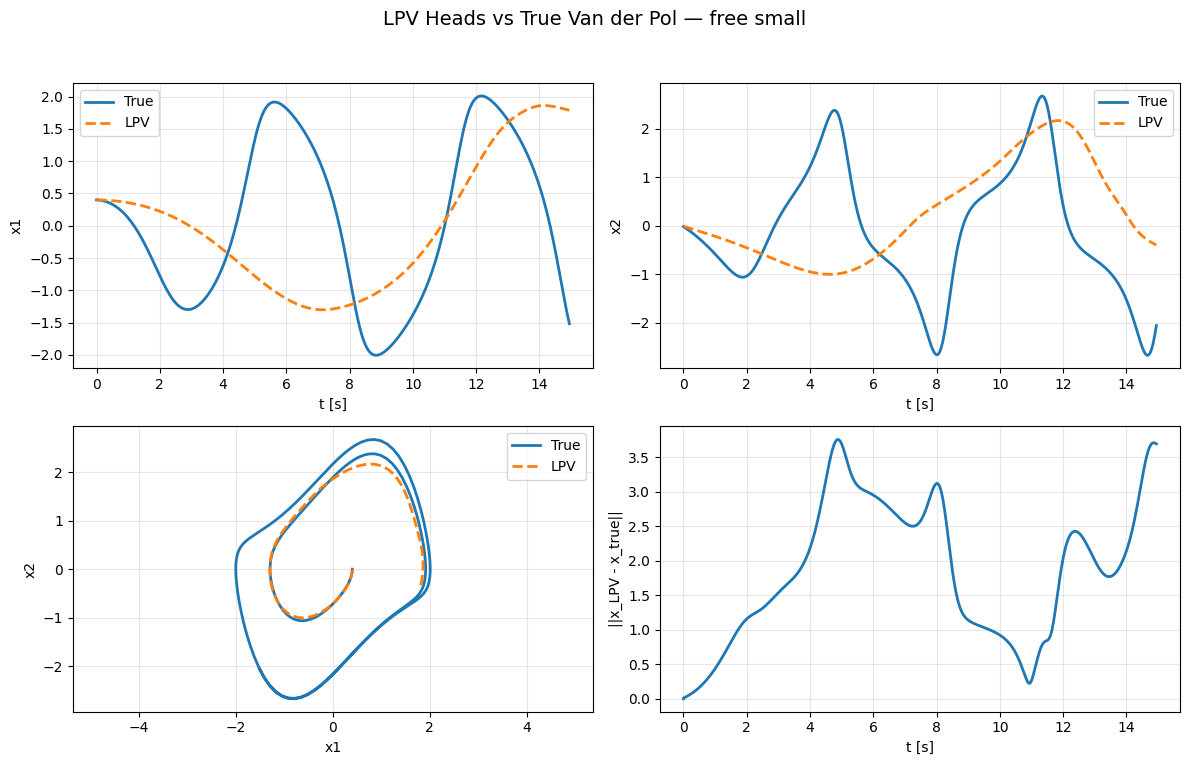

[free large]  RMSE=1.7044  MAE=1.3361  MaxAbs=3.8679  (T=300 steps)
Saved: lpv_vs_true_plots/compare_free_large.png


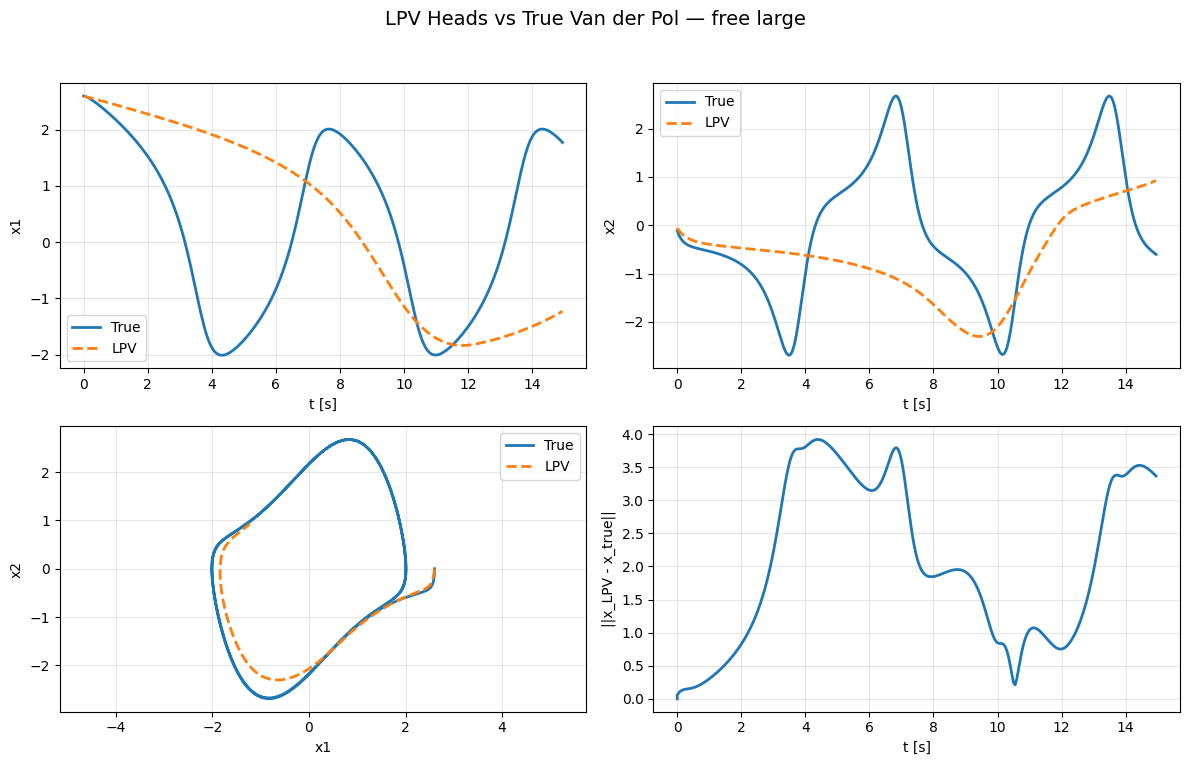

[sine 0.35Hz]  RMSE=1.4474  MAE=1.1670  MaxAbs=3.3746  (T=300 steps)
Saved: lpv_vs_true_plots/compare_sine_0.35Hz.png


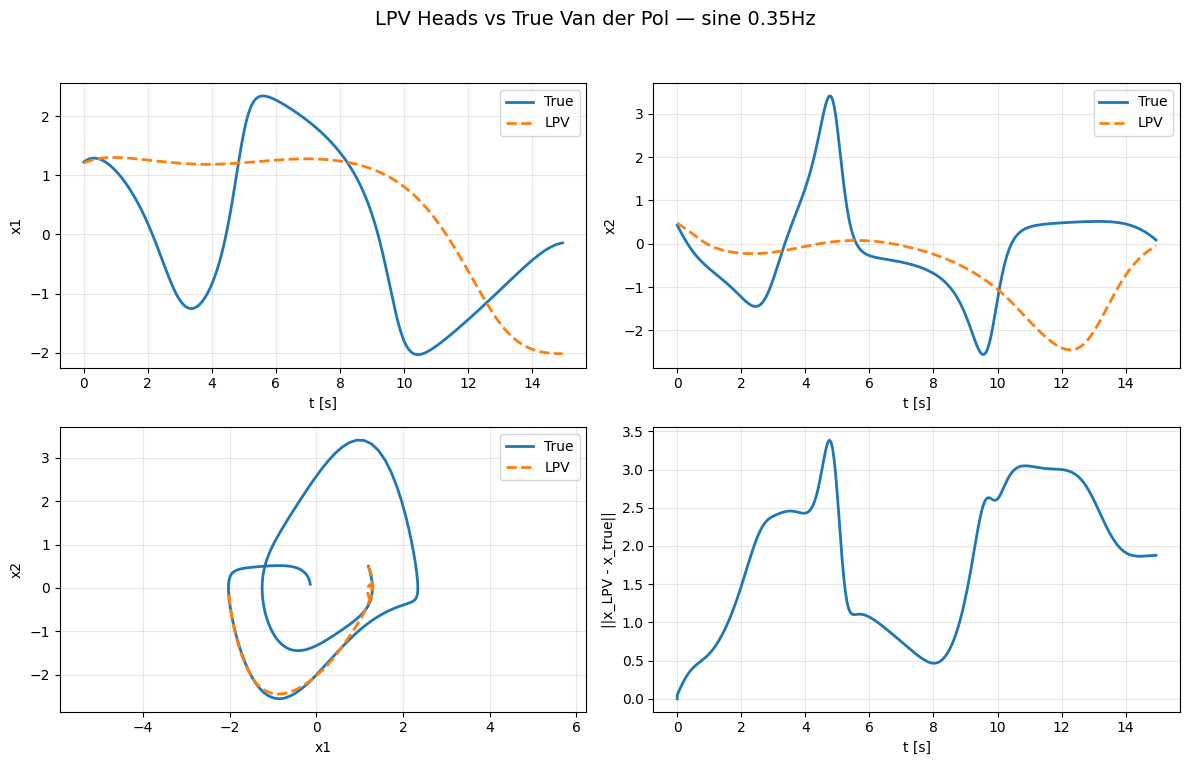

[const +1.3]  RMSE=0.4865  MAE=0.3571  MaxAbs=0.8073  (T=300 steps)
Saved: lpv_vs_true_plots/compare_const_+1.3.png


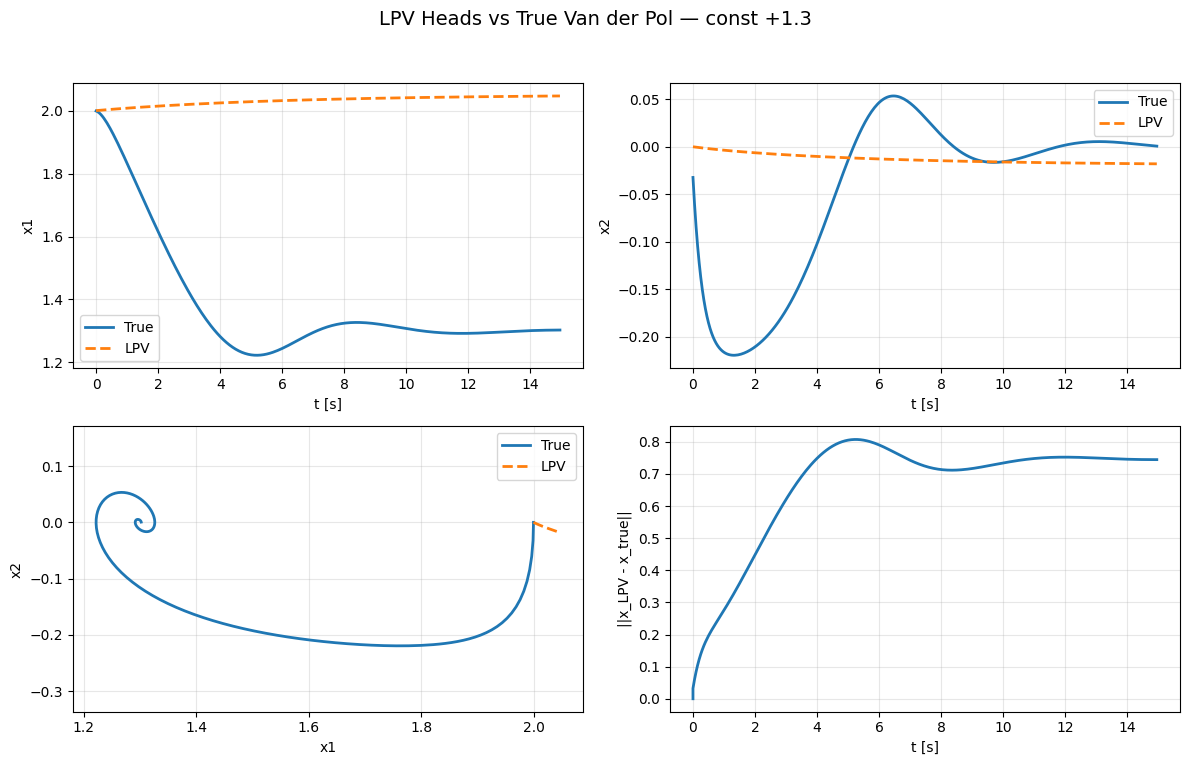

[PRBS-ish 0.25Hz]  RMSE=1.5732  MAE=1.2617  MaxAbs=3.7088  (T=300 steps)
Saved: lpv_vs_true_plots/compare_PRBS-ish_0.25Hz.png


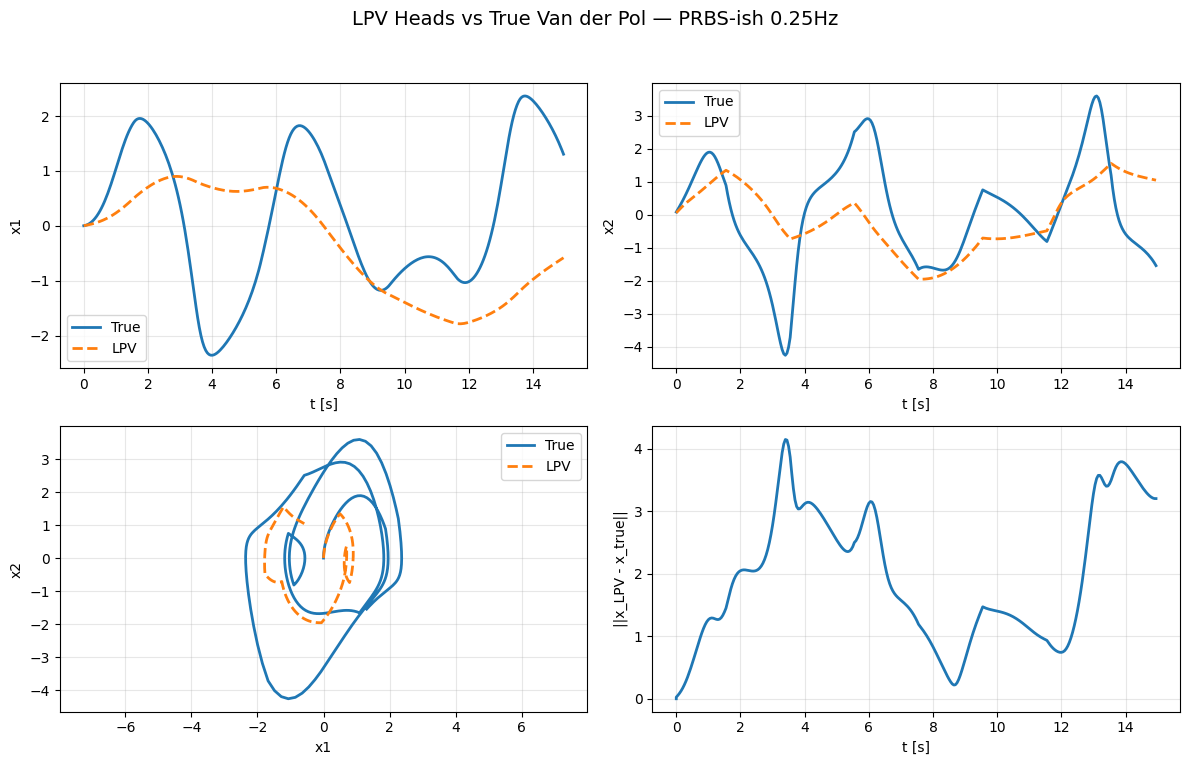


Aggregate  RMSE=1.4084  MAE=1.0587  MaxAbs=3.8679


In [9]:
# =========================
# LPV-vs-True Evaluation
# =========================


@torch.no_grad()
def lpv_rhs_from_heads(
    model: AELPV_PINN, y: torch.Tensor, u: torch.Tensor
) -> torch.Tensor:
    """
    Continuous-time RHS from your learned LPV heads:
        dy/dt = A(ρ(y)) y + B(ρ(y)) u
    """
    dy_lpv, _, _, _, _ = model.lpv_dynamics_from_state(y, u)
    return dy_lpv


def rk4_step_true_vdp(
    y: torch.Tensor, u: torch.Tensor, dt: float, mu: float
) -> torch.Tensor:
    k1 = vdp_f_torch(y, u, mu)
    k2 = vdp_f_torch(y + 0.5 * dt * k1, u, mu)
    k3 = vdp_f_torch(y + 0.5 * dt * k2, u, mu)
    k4 = vdp_f_torch(y + dt * k3, u, mu)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


@torch.no_grad()
def rk4_step_lpv_heads(
    model: AELPV_PINN, y: torch.Tensor, u: torch.Tensor, dt: float
) -> torch.Tensor:
    # dy/dt from the learned LPV ODE: A(θ(y,u)) y + B(θ(y,u)) u
    k1, *_ = model.lpv_dynamics_from_state(y, u)
    k2, *_ = model.lpv_dynamics_from_state(y + 0.5 * dt * k1, u)
    k3, *_ = model.lpv_dynamics_from_state(y + 0.5 * dt * k2, u)
    k4, *_ = model.lpv_dynamics_from_state(y + dt * k3, u)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


def rollout_true_vdp(
    x0: np.ndarray, u_seq: np.ndarray, dt: float, mu: float, device="cpu"
) -> np.ndarray:
    y = torch.tensor(x0, dtype=torch.float32, device=device).unsqueeze(0)
    traj = [y.clone()]
    for k in range(len(u_seq)):
        u = torch.tensor([[u_seq[k]]], dtype=torch.float32, device=device)
        y = rk4_step_true_vdp(y, u, dt, mu)
        traj.append(y.clone())
    return torch.cat(traj, dim=0).cpu().numpy()

@torch.no_grad()
def rollout_lpv_mpc(model: AELPV_PINN, x0: np.ndarray, y_ref_seq: np.ndarray, dt: float, device="cpu") -> np.ndarray:
    model.eval()
    y = torch.tensor(x0, dtype=torch.float32, device=device).unsqueeze(0)
    traj = [y.clone()]
    for k in range(len(y_ref_seq)):
        y_ref = torch.tensor([y_ref_seq[k]], dtype=torch.float32, device=device)
        _, aux = model(torch.tensor([[dt]], device=device), y, torch.zeros_like(y), y_ref=y_ref, return_aux=True)
        u = aux['u_hat'] if aux['u_hat'] is not None else torch.zeros_like(y[:, :1])
        y = rk4_step_lpv_heads(model, y, u, dt)
        traj.append(y.clone())
    return torch.cat(traj, dim=0).cpu().numpy()

@torch.no_grad()
def rollout_lpv_heads(
    model: AELPV_PINN, x0: np.ndarray, u_seq: np.ndarray, dt: float, device="cpu"
) -> np.ndarray:
    model.eval()
    y = torch.tensor(x0, dtype=torch.float32, device=device).unsqueeze(0)
    traj = [y.clone()]
    for k in range(len(u_seq)):
        u = torch.tensor([[u_seq[k]]], dtype=torch.float32, device=device)
        y = rk4_step_lpv_heads(model, y, u, dt)
        traj.append(y.clone())
    return torch.cat(traj, dim=0).cpu().numpy()

def compare_lpv_to_true(
    model: AELPV_PINN, mu: float, dt: float, test_cases: List[Dict], device: str = "cpu"
) -> Dict[str, float]:
    """
    Runs each case, compares open-loop and MPC rollouts, prints RMSE/MAE, and returns aggregate stats.
    Each test case is: {'x0': np.array([x1,x2]), 'u_seq': np.array(T,), 'label': str}
    """
    all_errs = []
    for case in test_cases:
        x0 = case["x0"]
        useq = case["u_seq"]
        lab = case.get("label", "case")
        # Open-loop rollout
        traj_true = rollout_true_vdp(x0, useq, dt, mu, device=device)
        traj_lpv_open = rollout_lpv_heads(model, x0, useq, dt, device=device)
        err_open = traj_lpv_open - traj_true
        rmse_open = float(np.sqrt(np.mean(err_open**2)))
        mae_open = float(np.mean(np.abs(err_open)))
        mx_open = float(np.max(np.abs(err_open)))
        # MPC rollout (track origin as reference)
        y_ref_seq = np.zeros_like(traj_true)  # Example: stabilize to origin
        traj_lpv_mpc = rollout_lpv_mpc(model, x0, y_ref_seq, dt, device=device)
        err_mpc = traj_lpv_mpc - traj_true
        rmse_mpc = float(np.sqrt(np.mean(err_mpc**2)))
        mae_mpc = float(np.mean(np.abs(err_mpc)))
        mx_mpc = float(np.max(np.abs(err_mpc)))
        print(f"[{lab}] Open-Loop RMSE={rmse_open:.4f} MAE={mae_open:.4f} MaxAbs={mx_open:.4f} | "
              f"MPC RMSE={rmse_mpc:.4f} MAE={mae_mpc:.4f} MaxAbs={mx_mpc:.4f} (T={len(useq)} steps)")
        all_errs.append(err_open)  # Aggregate open-loop errors (can add MPC if desired)
    all_errs = np.concatenate(all_errs, axis=0)
    agg = dict(
        RMSE=float(np.sqrt(np.mean(all_errs**2))),
        MAE=float(np.mean(np.abs(all_errs))),
        MaxAbs=float(np.max(np.abs(all_errs)))
    )
    print(f"\nAggregate RMSE={agg['RMSE']:.4f} MAE={agg['MAE']:.4f} MaxAbs={agg['MaxAbs']:.4f}")
    return agg

# -------------------------
# Example: evaluation-only
# -------------------------
def eval_only(
    model: AELPV_PINN,
    dt: float = 0.05,
    mu: float = 1.0,
    device: Optional[str] = None,
    save_dir: Optional[str] = "lpv_vs_true_plots",
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Build the SAME architecture you trained (heads are what we need)
    model = model

    # Scenarios
    Tsim = 300
    tvec = np.arange(Tsim) * dt
    tests = [
        dict(
            x0=np.array([0.4, 0.0], dtype=np.float32),
            u_seq=np.zeros(Tsim, dtype=np.float32),
            label="free small",
        ),
        dict(
            x0=np.array([2.6, 0.0], dtype=np.float32),
            u_seq=np.zeros(Tsim, dtype=np.float32),
            label="free large",
        ),
        dict(
            x0=np.array([1.2, 0.5], dtype=np.float32),
            u_seq=(1.0 * np.sin(0.35 * tvec)).astype(np.float32),
            label="sine 0.35Hz",
        ),
        dict(
            x0=np.array([2.0, 0.0], dtype=np.float32),
            u_seq=np.ones(Tsim, dtype=np.float32) * 1.3,
            label="const +1.3",
        ),
        dict(
            x0=np.array([0.0, 0.0], dtype=np.float32),
            u_seq=(np.sign(np.sin(2 * np.pi * 0.25 * tvec + 0.7)) * 1.5).astype(
                np.float32
            ),
            label="PRBS-ish 0.25Hz",
        ),
    ]

    # Compare + plots
    compare_lpv_to_true_with_plots(
        model, mu=mu, dt=dt, test_cases=tests, device=device, save_dir=save_dir
    )


eval_only(model, dt=0.05, mu=1.0, device=device, save_dir="lpv_vs_true_plots")


Saved: lpv_vs_true_plots/eigdiag_free_small_lpv.png


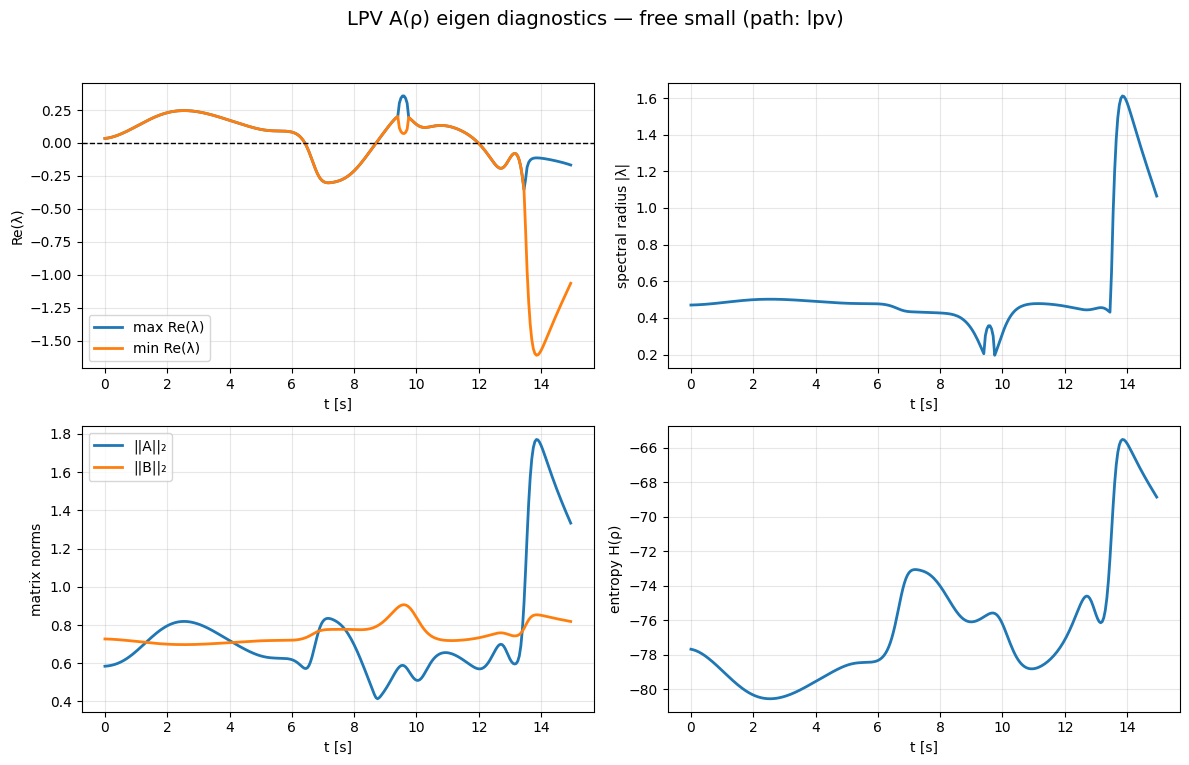

[free small/lpv] max Re(λ) over path: 0.357 | median Re(λ): 0.090
Saved: lpv_vs_true_plots/eigdiag_free_small_true.png


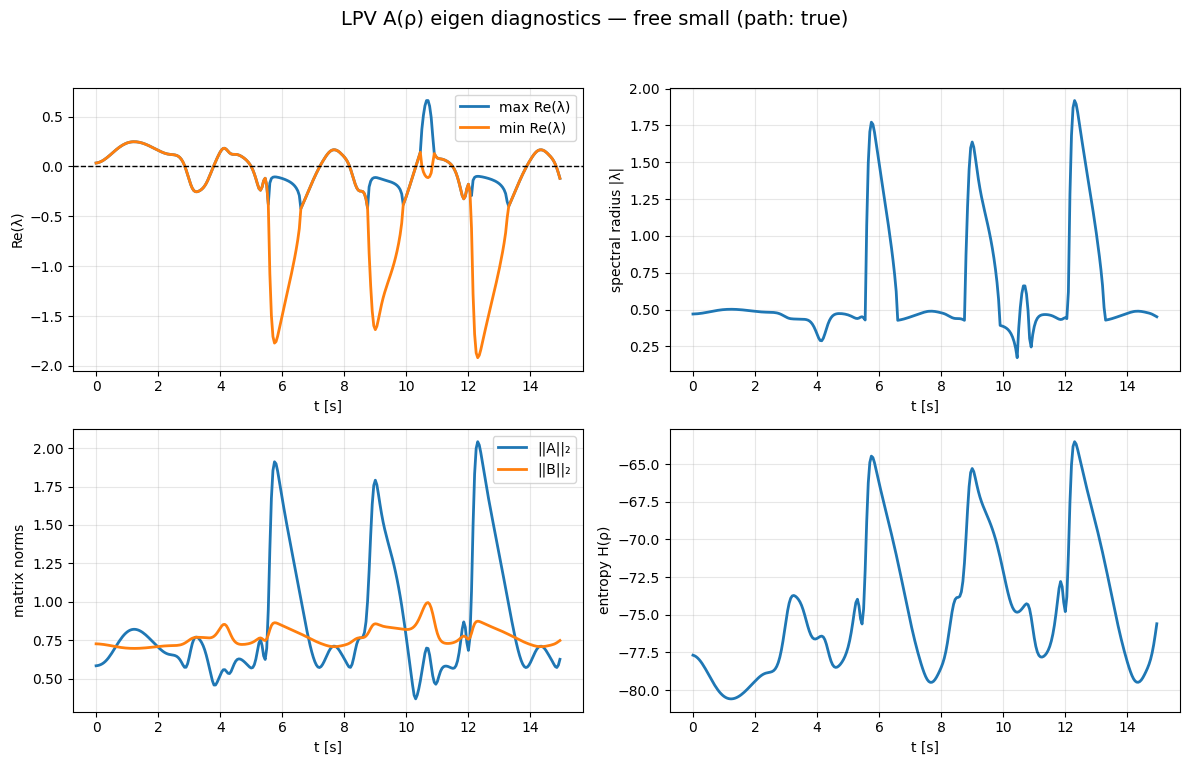

[free small/true] max Re(λ) over path: 0.661 | median Re(λ): -0.026


{'max_real': 0.6609712243080139,
 'median_real': -0.02553688734769821,
 'max_spec': 1.91832435131073}

In [ ]:
# =========================
# LPV stability diagnostics
# =========================
import numpy as np
import matplotlib.pyplot as plt


@torch.no_grad()
def _heads_on_path(
    model: AELPV_PINN, path_y: np.ndarray, u_seq: np.ndarray, device="cpu"
):
    """
    Evaluate A(ρ), B(ρ), ρ and eigenvalues of A along a provided state path.
    path_y: (T+1,2) numpy, states y_0..y_T
    u_seq : (T,) numpy, controls u_0..u_{T-1}
    """
    T = len(u_seq)
    eigvals = np.zeros((T, 2), dtype=np.complex64)
    A_norm = np.zeros(T, dtype=np.float32)
    B_norm = np.zeros(T, dtype=np.float32)
    rho_E = np.zeros(T, dtype=np.float32)  # entropy of rho

    for k in range(T):
        yk = torch.tensor(path_y[k], dtype=torch.float32, device=device).unsqueeze(
            0
        )  # [1,2]
        uk = torch.tensor([[u_seq[k]]], dtype=torch.float32, device=device)  # [1,1]
        # heads at *current* y
        _, rho, A, B, _ = model.lpv_dynamics_from_state(yk, uk)
        A_np = A.squeeze(0).cpu().numpy()  # 2x2
        B_np = B.squeeze(0).cpu().numpy()  # 2x1
        ev = np.linalg.eigvals(A_np)
        eigvals[k] = ev
        # norms + entropy
        A_norm[k] = np.linalg.norm(A_np, 2)
        B_norm[k] = np.linalg.norm(B_np, 2)
        rho_np = rho.squeeze(0).cpu().numpy()
        rho_E[k] = -np.sum(rho_np * np.log(np.clip(rho_np, 1e-12, 1.0))).astype(
            np.float32
        )

    return eigvals, A_norm, B_norm, rho_E


def diagnose_case(
    model: AELPV_PINN,
    x0: np.ndarray,
    u_seq: np.ndarray,
    dt: float,
    mu: float = 1.0,
    device: str = "cpu",
    source: str = "lpv",  # 'lpv' or 'true' path for evaluating heads
    label: str = "case",
    save_dir: str = None,
):
    """
    Rollout chosen path, evaluate heads, and plot eigen-diagnostics.
    - source='lpv': evaluate along the LPV rollout (self-consistency)
    - source='true': evaluate along the true VdP rollout (policy under true dynamics)
    """
    assert source in ("lpv", "true")
    if source == "lpv":
        traj = rollout_lpv_heads(model, x0, u_seq, dt, device=device)  # (T+1,2)
    else:
        traj = rollout_true_vdp(x0, u_seq, dt, mu, device=device)

    eigvals, A_norm, B_norm, rho_E = _heads_on_path(model, traj, u_seq, device=device)
    tvec = np.arange(len(u_seq)) * dt

    re_max = np.maximum(eigvals[:, 0].real, eigvals[:, 1].real)
    re_min = np.minimum(eigvals[:, 0].real, eigvals[:, 1].real)
    rho_spec = np.maximum(np.abs(eigvals[:, 0]), np.abs(eigvals[:, 1]))

    # --- plots ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"LPV A(ρ) eigen diagnostics — {label} (path: {source})", fontsize=14)

    # Real parts of eigenvalues
    axes[0, 0].plot(tvec, re_max, lw=2, label="max Re(λ)")
    axes[0, 0].plot(tvec, re_min, lw=2, label="min Re(λ)")
    axes[0, 0].axhline(0.0, color="k", ls="--", lw=1)
    axes[0, 0].set_xlabel("t [s]")
    axes[0, 0].set_ylabel("Re(λ)")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Spectral radius
    axes[0, 1].plot(tvec, rho_spec, lw=2)
    axes[0, 1].set_xlabel("t [s]")
    axes[0, 1].set_ylabel("spectral radius |λ|")
    axes[0, 1].grid(True, alpha=0.3)

    # Norms of A and B
    axes[1, 0].plot(tvec, A_norm, lw=2, label="||A||₂")
    axes[1, 0].plot(tvec, B_norm, lw=2, label="||B||₂")
    axes[1, 0].set_xlabel("t [s]")
    axes[1, 0].set_ylabel("matrix norms")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # Scheduler entropy
    axes[1, 1].plot(tvec, rho_E, lw=2)
    axes[1, 1].set_xlabel("t [s]")
    axes[1, 1].set_ylabel("entropy H(ρ)")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out = os.path.join(save_dir, f"eigdiag_{label.replace(' ', '_')}_{source}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"Saved: {out}")
    plt.show()

    # quick textual summary
    print(
        f"[{label}/{source}] max Re(λ) over path: {re_max.max():.3f} | "
        f"median Re(λ): {np.median(re_max):.3f}"
    )
    return dict(
        max_real=float(re_max.max()),
        median_real=float(np.median(re_max)),
        max_spec=float(rho_spec.max()),
    )


model = model
# Example scenario (same as your "free small")
dt = 0.05
mu = 1.0
x0 = np.array([0.4, 0.0], dtype=np.float32)
Tsim = 300
u_seq = np.zeros(Tsim, dtype=np.float32)

# along the LPV rollout (self-consistency)
diagnose_case(
    model,
    x0,
    u_seq,
    dt,
    mu,
    device=device,
    source="lpv",
    label="free small",
    save_dir="lpv_vs_true_plots",
)

# along the TRUE Van der Pol path (what A(ρ) would be if the state followed physics)
diagnose_case(
    model,
    x0,
    u_seq,
    dt,
    mu,
    device=device,
    source="true",
    label="free small",
    save_dir="lpv_vs_true_plots",
)
